In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loaded 63084 rows from: /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner.csv
Rows after dropping missing mean_agency_score: 63084

=== Overall distribution of combined mean_agency_score ===
count    63084.000000
mean        -0.047490
std          0.334549
min         -0.993539
25%         -0.318249
50%         -0.062056
75%          0.199319
max          0.951101
Name: mean_agency_score, dtype: float64
Mean agency score (95% CI): -0.047 [-0.050, -0.045]


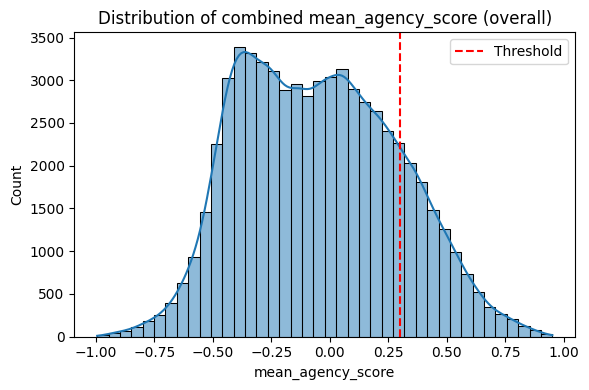


=== Combined 3-way label counts ===
combined_soa_label
NEG_SOA    30095
POS_SOA    17278
NON_SOA    15711
Name: count, dtype: int64

=== Group-wise descriptives for mean_agency_score by combined label ===

Label: NEG_SOA
count    30095.000000
mean        -0.333825
std          0.164448
min         -0.993539
25%         -0.438974
50%         -0.329231
75%         -0.211723
max         -0.000150
Name: mean_agency_score, dtype: float64
Mean (95% CI): -0.334 [-0.336, -0.332]

Label: NON_SOA
count    15711.000000
mean         0.048350
std          0.105782
min         -0.294370
25%         -0.027278
50%          0.048580
75%          0.128303
max          0.297796
Name: mean_agency_score, dtype: float64
Mean (95% CI): 0.048 [0.047, 0.050]

Label: POS_SOA
count    17278.000000
mean         0.364102
std          0.175482
min          0.000144
25%          0.247124
50%          0.349041
75%          0.472539
max          0.951101
Name: mean_agency_score, dtype: float64
Mean (95% CI): 0.364 [0

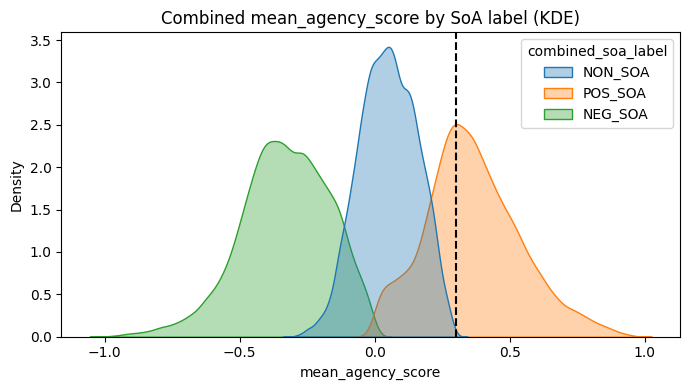


=== BART agency score stats ===
count    63084.000000
mean        -0.226911
std          0.556611
min         -0.999525
25%         -0.753140
50%         -0.260059
75%          0.220790
max          0.987875
Name: bart-large-mnli_agency_score, dtype: float64

=== RoBERTa agency score stats ===
count    63084.000000
mean         0.131930
std          0.232629
min         -0.994487
25%          0.013224
50%          0.128946
75%          0.258929
max          0.956430
Name: roberta-large-mnli_agency_score, dtype: float64

Correlation between model-specific agency scores:
                                 bart-large-mnli_agency_score  \
bart-large-mnli_agency_score                         1.000000   
roberta-large-mnli_agency_score                      0.323438   

                                 roberta-large-mnli_agency_score  
bart-large-mnli_agency_score                            0.323438  
roberta-large-mnli_agency_score                         1.000000  

=== Threshold scan summar

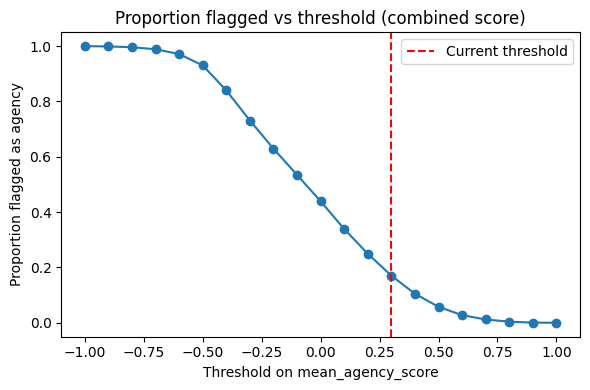


=== Label distributions per method ===

bart_soa_label:
bart_soa_label
NEG_SOA    30385
NON_SOA    19321
POS_SOA    13378
Name: count, dtype: int64

roberta_soa_label:
roberta_soa_label
NON_SOA    48288
POS_SOA    12333
NEG_SOA     2463
Name: count, dtype: int64

combined_soa_label:
combined_soa_label
NEG_SOA    30095
POS_SOA    17278
NON_SOA    15711
Name: count, dtype: int64

=== Pairwise agreement (percent agreement + Cohen's kappa) ===

Pair: bart_soa_label vs roberta_soa_label
  Percent agreement: 0.356
  Cohen's kappa:    0.087
  Confusion matrix:
roberta_soa_label  NEG_SOA  NON_SOA  POS_SOA
bart_soa_label                              
NEG_SOA               1953    24200     4232
NON_SOA                318    15711     3292
POS_SOA                192     8377     4809

Pair: bart_soa_label vs combined_soa_label
  Percent agreement: 0.931
  Cohen's kappa:    0.891
  Confusion matrix:
combined_soa_label  NEG_SOA  NON_SOA  POS_SOA
bart_soa_label                               
NEG_S

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Config

INPUT_FILE = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner.csv"

# Threshold only used for plotting / intuition on mean_agency_score
AGENCY_THRESHOLD = 0.3

# Expected columns
SCORE_COL_COMBINED = "mean_agency_score"               # combined continuous score
SCORE_COL_BART     = "bart-large-mnli_agency_score"
SCORE_COL_ROBERTA  = "roberta-large-mnli_agency_score"

LABEL_COL_BART     = "bart_soa_label"
LABEL_COL_ROBERTA  = "roberta_soa_label"
LABEL_COL_COMBINED = "combined_soa_label"

# Optional flags (if present)
FLAG_COL_BART      = "bart_agency_related"
FLAG_COL_ROBERTA   = "roberta_agency_related"
FLAG_COL_COMBINED  = "combined_agency_related"

# Allowed categorical labels
VALID_LABELS = ["POS_SOA", "NEG_SOA", "NON_SOA"]

# 2. Load data

df = pd.read_csv(INPUT_FILE)

print(f"Loaded {len(df)} rows from: {INPUT_FILE}")

for c in [SCORE_COL_COMBINED, SCORE_COL_BART, SCORE_COL_ROBERTA,
          LABEL_COL_BART, LABEL_COL_ROBERTA, LABEL_COL_COMBINED]:
    if c not in df.columns:
        print(f"WARNING: expected column '{c}' not found in input.")

# coerce scores to numeric
for col in [SCORE_COL_COMBINED, SCORE_COL_BART, SCORE_COL_ROBERTA]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# drop rows with no combined score
df = df.dropna(subset=[SCORE_COL_COMBINED])
print(f"Rows after dropping missing {SCORE_COL_COMBINED}: {len(df)}")


# 3. Helper: mean + CI

def mean_confidence_interval(x, confidence=0.95):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    m = np.mean(x)
    se = stats.sem(x)
    h = se * stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return m, m - h, m + h


# 4. Overall descriptives for combined score

print("\n=== Overall distribution of combined mean_agency_score ===")
print(df[SCORE_COL_COMBINED].describe())

overall_mean, overall_lo, overall_hi = mean_confidence_interval(df[SCORE_COL_COMBINED])
print(
    f"Mean agency score (95% CI): {overall_mean:.3f} "
    f"[{overall_lo:.3f}, {overall_hi:.3f}]"
)

plt.figure(figsize=(6, 4))
sns.histplot(df[SCORE_COL_COMBINED], bins=40, kde=True)
plt.axvline(AGENCY_THRESHOLD, color="red", linestyle="--", label="Threshold")
plt.title("Distribution of combined mean_agency_score (overall)")
plt.xlabel(SCORE_COL_COMBINED)
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


# 5. Distribution and descriptives by 3-way combined label

if LABEL_COL_COMBINED in df.columns:
    print("\n=== Combined 3-way label counts ===")
    print(df[LABEL_COL_COMBINED].value_counts(dropna=False))

    print("\n=== Group-wise descriptives for mean_agency_score by combined label ===")
    for lab, sub in df.groupby(LABEL_COL_COMBINED):
        desc = sub[SCORE_COL_COMBINED].describe()
        m, lo, hi = mean_confidence_interval(sub[SCORE_COL_COMBINED])
        print(f"\nLabel: {lab}")
        print(desc)
        print(f"Mean (95% CI): {m:.3f} [{lo:.3f}, {hi:.3f}]")

    # KDE plot by label
    plt.figure(figsize=(7, 4))
    sns.kdeplot(
        data=df,
        x=SCORE_COL_COMBINED,
        hue=LABEL_COL_COMBINED,
        common_norm=False,
        fill=True,
        alpha=0.35
    )
    plt.axvline(AGENCY_THRESHOLD, color="black", linestyle="--", label="Threshold")
    plt.title("Combined mean_agency_score by SoA label (KDE)")
    plt.xlabel(SCORE_COL_COMBINED)
    plt.tight_layout()
    plt.show()

# 6. Per-model descriptive stats

if SCORE_COL_BART in df.columns:
    print("\n=== BART agency score stats ===")
    print(df[SCORE_COL_BART].describe())

if SCORE_COL_ROBERTA in df.columns:
    print("\n=== RoBERTa agency score stats ===")
    print(df[SCORE_COL_ROBERTA].describe())

if SCORE_COL_BART in df.columns and SCORE_COL_ROBERTA in df.columns:
    print("\nCorrelation between model-specific agency scores:")
    print(df[[SCORE_COL_BART, SCORE_COL_ROBERTA]].corr())

# 7. Threshold scan on combined score (same as before, just for intuition)

def threshold_scan(scores, thresholds):
    results = []
    x = np.array(scores)
    for t in thresholds:
        mask = x > t
        n_flag = mask.sum()
        prop_flag = n_flag / len(x)
        mean_flag = x[mask].mean() if n_flag > 0 else np.nan
        mean_rest = x[~mask].mean() if n_flag < len(x) else np.nan
        results.append(
            {
                "threshold": t,
                "prop_flagged": prop_flag,
                "mean_flagged": mean_flag,
                "mean_unflagged": mean_rest,
            }
        )
    return pd.DataFrame(results)


thresholds = np.linspace(-1.0, 1.0, 21)
scan_df = threshold_scan(df[SCORE_COL_COMBINED].values, thresholds)

print("\n=== Threshold scan summary (combined score) ===")
print(scan_df.head(10))

plt.figure(figsize=(6, 4))
plt.plot(scan_df["threshold"], scan_df["prop_flagged"], marker="o")
plt.axvline(AGENCY_THRESHOLD, color="red", linestyle="--", label="Current threshold")
plt.xlabel("Threshold on mean_agency_score")
plt.ylabel("Proportion flagged as agency")
plt.title("Proportion flagged vs threshold (combined score)")
plt.legend()
plt.tight_layout()
plt.show()


# 8. Agreement metrics: helpers

def cohen_kappa_nominal(y1, y2):
    """
    Cohen's kappa for two nominal labelings y1, y2 (arrays of strings).
    """
    s1 = pd.Series(y1)
    s2 = pd.Series(y2)
    mask = s1.notna() & s2.notna()
    s1 = s1[mask]
    s2 = s2[mask]
    if len(s1) == 0:
        return np.nan, np.nan, None

    # confusion matrix
    cm = pd.crosstab(s1, s2)
    N = cm.values.sum()
    # observed agreement
    po = np.trace(cm.values) / N

    # expected agreement
    row_marg = cm.sum(axis=1).values
    col_marg = cm.sum(axis=0).values
    pe = (row_marg * col_marg).sum() / (N ** 2)

    kappa = (po - pe) / (1 - pe) if (1 - pe) != 0 else np.nan
    return po, kappa, cm


def krippendorff_alpha_nominal(data_2d):
    """
    Krippendorff's alpha for nominal data.
    data_2d: array-like of shape (n_items, n_raters), entries can be strings/ints.
    """
    df_r = pd.DataFrame(data_2d)
    long = df_r.stack().reset_index()
    long.columns = ["item", "rater", "value"]
    long = long.dropna(subset=["value"])

    # map categories to integers
    cats, long["cat"] = np.unique(long["value"], return_inverse=True)

    # counts per item x category
    item_cat = long.groupby(["item", "cat"])["rater"].count().unstack(fill_value=0)

    # observed disagreement Do
    n_u = item_cat.sum(axis=1).values  # ratings per item
    Do_num = 0.0
    total_weight = 0.0
    for idx, row in item_cat.iterrows():
        n = n_u[item_cat.index.get_loc(idx)]
        if n <= 1:
            continue
        counts = row.values
        Do_num += (counts * (n - counts)).sum() / (n - 1)
        total_weight += n
    Do = Do_num / total_weight if total_weight > 0 else np.nan

    # expected disagreement De
    cat_totals = item_cat.sum(axis=0).values
    N = cat_totals.sum()
    if N <= 1:
        return np.nan
    De = (cat_totals * (N - cat_totals)).sum() / ((N - 1) * N)

    if De == 0:
        return np.nan
    return 1 - Do / De


# 9. Agreement: pairwise Cohen's kappa and overall Krippendorff's alpha

label_cols = [LABEL_COL_BART, LABEL_COL_ROBERTA, LABEL_COL_COMBINED]
present_label_cols = [c for c in label_cols if c in df.columns]

print("\n=== Label distributions per method ===")
for c in present_label_cols:
    print(f"\n{c}:")
    print(df[c].value_counts(dropna=False))

# Pairwise Cohen's kappa
pairs = [
    (LABEL_COL_BART, LABEL_COL_ROBERTA),
    (LABEL_COL_BART, LABEL_COL_COMBINED),
    (LABEL_COL_ROBERTA, LABEL_COL_COMBINED),
]

print("\n=== Pairwise agreement (percent agreement + Cohen's kappa) ===")
for a, b in pairs:
    if a not in df.columns or b not in df.columns:
        continue
    pa, kappa, cm = cohen_kappa_nominal(df[a], df[b])
    print(f"\nPair: {a} vs {b}")
    print(f"  Percent agreement: {pa:.3f}")
    print(f"  Cohen's kappa:    {kappa:.3f}")
    print("  Confusion matrix:")
    print(cm)

# Krippendorff's alpha across all three
if len(present_label_cols) >= 2:
    # construct items x raters matrix
    ratings_mat = df[present_label_cols].values
    alpha = krippendorff_alpha_nominal(ratings_mat)
    print("\n=== Krippendorff's alpha (nominal, across all methods) ===")
    print(f"Alpha: {alpha:.3f}")
else:
    print("\nNot enough label columns to compute Krippendorff's alpha.")


Loaded 63092 rows from: /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner.csv
Loaded 63084 rows from:   /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bertweet_student.csv
Deduped BERTweet file on 'proposition': 63084 -> 62708 rows.

After merge: 63092 rows total (same as main file).
Dropped 11 rows that had no matching BERTweet inference (non-overlapping propositions).
Rows after dropping missing mean_agency_score: 63081 (dropped 0)

=== Overall distribution of combined mean_agency_score ===
count    63081.000000
mean        -0.047512
std          0.334537
min         -0.993539
25%         -0.318313
50%         -0.062086
75%          0.199313
max          0.951101
Name: mean_agency_score, dtype: float64
Mean agency score (95% CI): -0.048 [-0.050, -0.045]


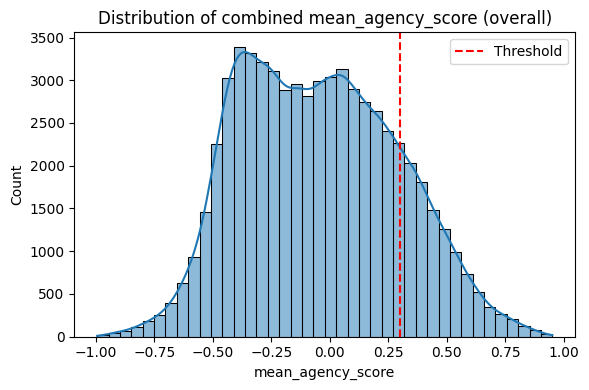


=== Combined 3-way label counts ===
combined_soa_label
NEG_SOA    30095
POS_SOA    17276
NON_SOA    15710
Name: count, dtype: int64

=== Group-wise descriptives for mean_agency_score by combined label ===

Label: NEG_SOA
count    30095.000000
mean        -0.333825
std          0.164448
min         -0.993539
25%         -0.438974
50%         -0.329231
75%         -0.211723
max         -0.000150
Name: mean_agency_score, dtype: float64
Mean (95% CI): -0.334 [-0.336, -0.332]

Label: NON_SOA
count    15710.000000
mean         0.048349
std          0.105785
min         -0.294370
25%         -0.027279
50%          0.048576
75%          0.128308
max          0.297796
Name: mean_agency_score, dtype: float64
Mean (95% CI): 0.048 [0.047, 0.050]

Label: POS_SOA
count    17276.000000
mean         0.364076
std          0.175473
min          0.000144
25%          0.247118
50%          0.349033
75%          0.472516
max          0.951101
Name: mean_agency_score, dtype: float64
Mean (95% CI): 0.364 [0

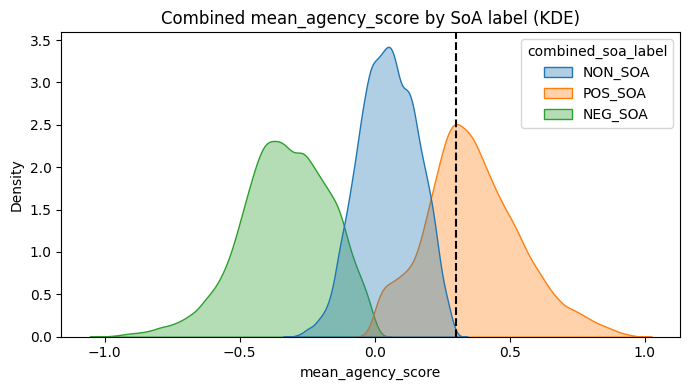


=== BART agency score stats ===
count    63081.000000
mean        -0.226951
std          0.556587
min         -0.999525
25%         -0.753167
50%         -0.260066
75%          0.220769
max          0.987875
Name: bart-large-mnli_agency_score, dtype: float64

=== RoBERTa agency score stats ===
count    63081.000000
mean         0.131926
std          0.232631
min         -0.994487
25%          0.013221
50%          0.128943
75%          0.258928
max          0.956430
Name: roberta-large-mnli_agency_score, dtype: float64

=== BERTweet student agency score stats ===
count    63081.000000
mean        -0.250502
std          0.513669
min         -0.972685
25%         -0.734045
50%         -0.282126
75%          0.164224
max          0.880035
Name: bertweet_agency_score, dtype: float64

Correlation matrix between model-specific agency scores:
                                 bart-large-mnli_agency_score  \
bart-large-mnli_agency_score                         1.000000   
roberta-large-mnli_ag

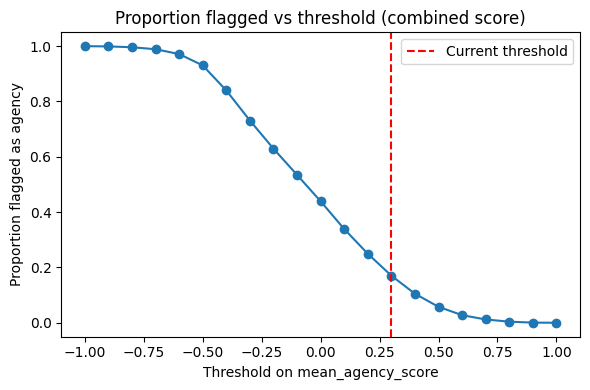


=== Label distributions per method ===

bart_soa_label:
bart_soa_label
NEG_SOA    30385
NON_SOA    19320
POS_SOA    13376
Name: count, dtype: int64

roberta_soa_label:
roberta_soa_label
NON_SOA    48286
POS_SOA    12332
NEG_SOA     2463
Name: count, dtype: int64

combined_soa_label:
combined_soa_label
NEG_SOA    30095
POS_SOA    17276
NON_SOA    15710
Name: count, dtype: int64

bertweet_soa_label:
bertweet_soa_label
NEG_SOA    30959
NON_SOA    20794
POS_SOA    11328
Name: count, dtype: int64

=== Pairwise agreement (percent agreement + Cohen's kappa) ===

Pair: bart_soa_label vs roberta_soa_label
  Percent agreement: 0.356
  Cohen's kappa:    0.087
  Confusion matrix:
roberta_soa_label  NEG_SOA  NON_SOA  POS_SOA
bart_soa_label                              
NEG_SOA               1953    24200     4232
NON_SOA                318    15710     3292
POS_SOA                192     8376     4808

Pair: bart_soa_label vs combined_soa_label
  Percent agreement: 0.931
  Cohen's kappa:    0.891


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Config

FILE_MAIN = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner.csv"
FILE_BERTWEET = "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bertweet_student.csv"

# Threshold only used for plotting / intuition on mean_agency_score
AGENCY_THRESHOLD = 0.3

# Score columns (existing)
SCORE_COL_COMBINED = "mean_agency_score"               # combined continuous score
SCORE_COL_BART     = "bart-large-mnli_agency_score"
SCORE_COL_ROBERTA  = "roberta-large-mnli_agency_score"

# New score column for BERTweet student
SCORE_COL_BERTWEET = "bertweet_agency_score"

# Label columns
LABEL_COL_BART      = "bart_soa_label"
LABEL_COL_ROBERTA   = "roberta_soa_label"
LABEL_COL_COMBINED  = "combined_soa_label"
LABEL_COL_BERTWEET  = "bertweet_soa_label"

# Optional flags (if present)
FLAG_COL_BART       = "bart_agency_related"
FLAG_COL_ROBERTA    = "roberta_agency_related"
FLAG_COL_COMBINED   = "combined_agency_related"
FLAG_COL_BERTWEET   = "bertweet_agency_related"

VALID_LABELS = ["POS_SOA", "NEG_SOA", "NON_SOA"]


# 2. Load and merge data (dedupe BERTweet; drop non-overlap)

df_main = pd.read_csv(FILE_MAIN, low_memory=False)
df_bt   = pd.read_csv(FILE_BERTWEET, low_memory=False)

print(f"Loaded {len(df_main)} rows from: {FILE_MAIN}")
print(f"Loaded {len(df_bt)} rows from:   {FILE_BERTWEET}")

if "proposition" not in df_main.columns or "proposition" not in df_bt.columns:
    raise KeyError("Both files must have a 'proposition' column for merge-based alignment.")

bt_cols = [
    "proposition",
    "bertweet_entailment",
    "bertweet_neutral",
    "bertweet_contradiction",
    "bertweet_agency_score",
    "bertweet_soa_label",
    "bertweet_agency_related",
]

missing_bt = [c for c in bt_cols if c not in df_bt.columns]
if missing_bt:
    raise KeyError(
        "Missing expected BERTweet columns in student file: "
        + ", ".join(missing_bt)
    )

# Deduplicate BERTweet side by proposition (keep first occurrence)
before_dedup_bt = len(df_bt)
df_bt_dedup = df_bt.drop_duplicates(subset=["proposition"]).copy()
after_dedup_bt = len(df_bt_dedup)
print(
    f"Deduped BERTweet file on 'proposition': "
    f"{before_dedup_bt} -> {after_dedup_bt} rows."
)

# Left-join main to deduped BERTweet on proposition
df_merged = pd.merge(
    df_main,
    df_bt_dedup[bt_cols],
    on="proposition",
    how="left",
)

print(f"\nAfter merge: {len(df_merged)} rows total (same as main file).")

# Drop rows with no BERTweet inference (these are the problematic extras)
before_drop = len(df_merged)
df_merged = df_merged.dropna(subset=["bertweet_agency_score"])
after_drop = len(df_merged)
print(
    f"Dropped {before_drop - after_drop} rows that had no matching BERTweet inference "
    "(non-overlapping propositions)."
)

df = df_merged.reset_index(drop=True)

# Coerce scores to numeric
for col in [SCORE_COL_COMBINED, SCORE_COL_BART, SCORE_COL_ROBERTA, SCORE_COL_BERTWEET]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

before = len(df)
df = df.dropna(subset=[SCORE_COL_COMBINED])
print(f"Rows after dropping missing {SCORE_COL_COMBINED}: {len(df)} (dropped {before - len(df)})")


# 3. Helper: mean + CI

def mean_confidence_interval(x, confidence=0.95):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    m = np.mean(x)
    se = stats.sem(x)
    h = se * stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return m, m - h, m + h


# 4. Overall descriptives for combined score

print("\n=== Overall distribution of combined mean_agency_score ===")
print(df[SCORE_COL_COMBINED].describe())

overall_mean, overall_lo, overall_hi = mean_confidence_interval(df[SCORE_COL_COMBINED])
print(
    f"Mean agency score (95% CI): {overall_mean:.3f} "
    f"[{overall_lo:.3f}, {overall_hi:.3f}]"
)

plt.figure(figsize=(6, 4))
sns.histplot(df[SCORE_COL_COMBINED], bins=40, kde=True)
plt.axvline(AGENCY_THRESHOLD, color="red", linestyle="--", label="Threshold")
plt.title("Distribution of combined mean_agency_score (overall)")
plt.xlabel(SCORE_COL_COMBINED)
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


# 5. Distribution and descriptives by 3-way combined label

if LABEL_COL_COMBINED in df.columns:
    print("\n=== Combined 3-way label counts ===")
    print(df[LABEL_COL_COMBINED].value_counts(dropna=False))

    print("\n=== Group-wise descriptives for mean_agency_score by combined label ===")
    for lab, sub in df.groupby(LABEL_COL_COMBINED):
        desc = sub[SCORE_COL_COMBINED].describe()
        m, lo, hi = mean_confidence_interval(sub[SCORE_COL_COMBINED])
        print(f"\nLabel: {lab}")
        print(desc)
        print(f"Mean (95% CI): {m:.3f} [{lo:.3f}, {hi:.3f}]")

    plt.figure(figsize=(7, 4))
    sns.kdeplot(
        data=df,
        x=SCORE_COL_COMBINED,
        hue=LABEL_COL_COMBINED,
        common_norm=False,
        fill=True,
        alpha=0.35
    )
    plt.axvline(AGENCY_THRESHOLD, color="black", linestyle="--", label="Threshold")
    plt.title("Combined mean_agency_score by SoA label (KDE)")
    plt.xlabel(SCORE_COL_COMBINED)
    plt.tight_layout()
    plt.show()


# 6. Per-model descriptive stats (BART, RoBERTa, BERTweet)

if SCORE_COL_BART in df.columns:
    print("\n=== BART agency score stats ===")
    print(df[SCORE_COL_BART].describe())

if SCORE_COL_ROBERTA in df.columns:
    print("\n=== RoBERTa agency score stats ===")
    print(df[SCORE_COL_ROBERTA].describe())

if SCORE_COL_BERTWEET in df.columns:
    print("\n=== BERTweet student agency score stats ===")
    print(df[SCORE_COL_BERTWEET].describe())

score_cols_present = [
    col for col in [SCORE_COL_BART, SCORE_COL_ROBERTA, SCORE_COL_BERTWEET]
    if col in df.columns
]
if len(score_cols_present) >= 2:
    print("\nCorrelation matrix between model-specific agency scores:")
    print(df[score_cols_present].corr())


# 7. Threshold scan on combined score

def threshold_scan(scores, thresholds):
    results = []
    x = np.array(scores)
    for t in thresholds:
        mask = x > t
        n_flag = mask.sum()
        prop_flag = n_flag / len(x)
        mean_flag = x[mask].mean() if n_flag > 0 else np.nan
        mean_rest = x[~mask].mean() if n_flag < len(x) else np.nan
        results.append(
            {
                "threshold": t,
                "prop_flagged": prop_flag,
                "mean_flagged": mean_flag,
                "mean_unflagged": mean_rest,
            }
        )
    return pd.DataFrame(results)


thresholds = np.linspace(-1.0, 1.0, 21)
scan_df = threshold_scan(df[SCORE_COL_COMBINED].values, thresholds)

print("\n=== Threshold scan summary (combined score) ===")
print(scan_df.head(10))

plt.figure(figsize=(6, 4))
plt.plot(scan_df["threshold"], scan_df["prop_flagged"], marker="o")
plt.axvline(AGENCY_THRESHOLD, color="red", linestyle="--", label="Current threshold")
plt.xlabel("Threshold on mean_agency_score")
plt.ylabel("Proportion flagged as agency")
plt.title("Proportion flagged vs threshold (combined score)")
plt.legend()
plt.tight_layout()
plt.show()


# 8. Agreement metrics: helpers

def cohen_kappa_nominal(y1, y2):
    """
    Cohen's kappa for two nominal labelings y1, y2 (arrays of strings).
    Returns (percent_agreement, kappa, confusion_matrix_df).
    """
    s1 = pd.Series(y1)
    s2 = pd.Series(y2)
    mask = s1.notna() & s2.notna()
    s1 = s1[mask]
    s2 = s2[mask]
    if len(s1) == 0:
        return np.nan, np.nan, None

    cm = pd.crosstab(s1, s2)
    N = cm.values.sum()
    po = np.trace(cm.values) / N  # observed agreement

    row_marg = cm.sum(axis=1).values
    col_marg = cm.sum(axis=0).values
    pe = (row_marg * col_marg).sum() / (N ** 2)  # expected agreement

    kappa = (po - pe) / (1 - pe) if (1 - pe) != 0 else np.nan
    return po, kappa, cm


def krippendorff_alpha_nominal(data_2d):
    """
    Krippendorff's alpha for nominal data.
    data_2d: array-like of shape (n_items, n_raters), entries can be strings/ints.
    """
    df_r = pd.DataFrame(data_2d)
    long = df_r.stack().reset_index()
    long.columns = ["item", "rater", "value"]
    long = long.dropna(subset=["value"])

    cats, long["cat"] = np.unique(long["value"], return_inverse=True)

    item_cat = long.groupby(["item", "cat"])["rater"].count().unstack(fill_value=0)

    n_u = item_cat.sum(axis=1).values
    Do_num = 0.0
    total_weight = 0.0
    for idx, row in item_cat.iterrows():
        n = n_u[item_cat.index.get_loc(idx)]
        if n <= 1:
            continue
        counts = row.values
        Do_num += (counts * (n - counts)).sum() / (n - 1)
        total_weight += n
    Do = Do_num / total_weight if total_weight > 0 else np.nan

    cat_totals = item_cat.sum(axis=0).values
    N = cat_totals.sum()
    if N <= 1:
        return np.nan
    De = (cat_totals * (N - cat_totals)).sum() / ((N - 1) * N)

    if De == 0:
        return np.nan
    return 1 - Do / De


# 9. Agreement: pairwise Cohen's kappa and Krippendorff's alpha

label_cols = [LABEL_COL_BART, LABEL_COL_ROBERTA, LABEL_COL_COMBINED, LABEL_COL_BERTWEET]
present_label_cols = [c for c in label_cols if c in df.columns]

print("\n=== Label distributions per method ===")
for c in present_label_cols:
    print(f"\n{c}:")
    print(df[c].value_counts(dropna=False))

pairs = []
for i in range(len(present_label_cols)):
    for j in range(i + 1, len(present_label_cols)):
        pairs.append((present_label_cols[i], present_label_cols[j]))

print("\n=== Pairwise agreement (percent agreement + Cohen's kappa) ===")
for a, b in pairs:
    pa, kappa, cm = cohen_kappa_nominal(df[a], df[b])
    print(f"\nPair: {a} vs {b}")
    print(f"  Percent agreement: {pa:.3f}")
    print(f"  Cohen's kappa:    {kappa:.3f}")
    print("  Confusion matrix:")
    print(cm)

if len(present_label_cols) >= 2:
    ratings_mat = df[present_label_cols].values
    alpha = krippendorff_alpha_nominal(ratings_mat)
    print("\n=== Krippendorff's alpha (nominal, across all methods) ===")
    print(f"Alpha: {alpha:.3f}")
else:
    print("\nNot enough label columns to compute Krippendorff's alpha.")


#z-Scoring by Model

In [ ]:
import pandas as pd
import numpy as np

# CONFIG

POS_THRESHOLD = 0.3

FILES = {
    "mean": "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels.csv",
    "winner": "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner.csv",
    "consensus": "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_consensus.csv",
    "bertweet": "/content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_bertweet_student.csv",
}

# Expected score columns per model.
# Adjust these if your actual column names differ.
MODEL_SCORE_COLS = {
    "BART": "bart-large-mnli_agency_score",
    "RoBERTa": "roberta-large-mnli_agency_score",
    # this is the per-row average of the two:
    "CombinedMean": "combined_agency_score",
    # in the bertweet file:
    "BERTweet": "bertweet_agency_score",  # change if needed
}

# FUNCTIONS

def summarize_score_series(scores: pd.Series, thresh: float, model_name: str):
    s = pd.to_numeric(scores, errors="coerce").dropna()
    if s.empty:
        print(f"  [{model_name}] no valid numeric scores; skipping.")
        return

    n = len(s)
    mean = s.mean()
    std = s.std(ddof=1)

    z_pos = (thresh - mean) / std
    z_neg = (-thresh - mean) / std

    prop_pos = (s >= thresh).mean()
    prop_neg = (s <= -thresh).mean()

    qs = s.quantile([0.05, 0.25, 0.5, 0.75, 0.95])

    print(f"  [{model_name}] n={n}")
    print(f"    mean={mean:.3f}, sd={std:.3f}")
    print(f"    z(+{thresh:.2f}) = {z_pos:.2f},  z(-{thresh:.2f}) = {z_neg:.2f}")
    print(f"    prop s>=+{thresh:.2f}: {prop_pos:.3f}")
    print(f"    prop s<=-{thresh:.2f}: {prop_neg:.3f}")
    print("    quantiles (0.05,0.25,0.50,0.75,0.95):")
    print("      ", ", ".join(f"{q:.3f}" for q in qs.values))


# MAIN LOOP

for label, path in FILES.items():
    print(f"\n=== File: {label} ===")
    print(f"Path: {path}")
    df = pd.read_csv(path)

    existing_cols = set(df.columns)

    # For each model, if its score column exists in this file, summarize it
    for model_name, col in MODEL_SCORE_COLS.items():
        if col in existing_cols:
            summarize_score_series(df[col], POS_THRESHOLD, model_name)
        else:
            print(f"  [{model_name}] column '{col}' not found in this file.")



=== File: mean ===
Path: /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels.csv
  [BART] n=63084
    mean=-0.227, sd=0.557
    z(+0.30) = 0.95,  z(-0.30) = -0.13
    prop s>=+0.30: 0.212
    prop s<=-0.30: 0.482
    quantiles (0.05,0.25,0.50,0.75,0.95):
       -0.973, -0.753, -0.260, 0.221, 0.728
  [RoBERTa] n=63084
    mean=0.132, sd=0.233
    z(+0.30) = 0.72,  z(-0.30) = -1.86
    prop s>=+0.30: 0.196
    prop s<=-0.30: 0.039
    quantiles (0.05,0.25,0.50,0.75,0.95):
       -0.251, 0.013, 0.129, 0.259, 0.520
  [CombinedMean] n=63084
    mean=-0.047, sd=0.335
    z(+0.30) = 1.04,  z(-0.30) = -0.75
    prop s>=+0.30: 0.170
    prop s<=-0.30: 0.269
    quantiles (0.05,0.25,0.50,0.75,0.95):
       -0.536, -0.318, -0.062, 0.199, 0.520
  [BERTweet] column 'bertweet_agency_score' not found in this file.

=== File: winner ===
Path: /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_winner.csv


/tmp/ipython-input-3596323704.py:60: DtypeWarning: Columns (1,3,4,5,6,16,17,20,22,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


  [BART] n=63083
    mean=-0.227, sd=0.557
    z(+0.30) = 0.95,  z(-0.30) = -0.13
    prop s>=+0.30: 0.212
    prop s<=-0.30: 0.482
    quantiles (0.05,0.25,0.50,0.75,0.95):
       -0.973, -0.753, -0.260, 0.221, 0.728
  [RoBERTa] n=63084
    mean=0.132, sd=0.233
    z(+0.30) = 0.72,  z(-0.30) = -1.86
    prop s>=+0.30: 0.196
    prop s<=-0.30: 0.039
    quantiles (0.05,0.25,0.50,0.75,0.95):
       -0.251, 0.013, 0.129, 0.259, 0.520
  [CombinedMean] n=63084
    mean=-0.047, sd=0.335
    z(+0.30) = 1.04,  z(-0.30) = -0.75
    prop s>=+0.30: 0.170
    prop s<=-0.30: 0.269
    quantiles (0.05,0.25,0.50,0.75,0.95):
       -0.536, -0.318, -0.062, 0.199, 0.520
  [BERTweet] column 'bertweet_agency_score' not found in this file.

=== File: consensus ===
Path: /content/drive/MyDrive/NLP /ai_human_agency_inferences_mnli_triple_labels_consensus.csv
  [BART] n=63084
    mean=-0.227, sd=0.557
    z(+0.30) = 0.95,  z(-0.30) = -0.13
    prop s>=+0.30: 0.212
    prop s<=-0.30: 0.482
    quantiles (0.05